In [1]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import matplotlib.pyplot as plt
from tqdm import tqdm

In [16]:
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.dropna().sample(5)

,,datetime,open,high,low,close,adj_close,volume,MktCap
Date,Ticker,,,,,,,,
2018-01-11,UDR,2018-01-11,36.4400,36.6100,36.0400,36.08,30.5606,1477778,9.789156e+09
2013-08-22,NI,2013-08-22,29.3199,29.4701,29.2001,29.38,8.6077,3244621,9.115261e+09
2009-05-13,MPWR,2009-05-13,16.7900,16.8700,16.2225,16.74,14.6335,623713,5.708102e+08
2017-01-24,FANG,2017-01-24,102.7200,104.2369,102.2800,103.74,89.1132,812979,7.885696e+09
2018-07-20,UHS,2018-07-20,112.4200,113.0800,111.7900,112.67,110.3240,435284,1.094343e+10


In [32]:
import pandas_ta as ta
from tqdm import tqdm
results ={}
for ticker in tqdm(market_data.index.get_level_values(1).unique()):
    df_ticker = market_data.xs(ticker,level=1)
    try :
        metrics = ta.decay(df_ticker[['close']].mean(1),length=10)
        metrics = metrics - ta.decay(df_ticker[['close']].shift(5).mean(1),length=10)
        results[ticker] = metrics

    except :
        print(ticker)

results = pd.concat(results,axis=1)
results = results.reindex_like(P).ffill()


100%|██████████| 866/866 [00:10<00:00, 85.64it/s] 


C:\Users\marti\AppData\Local\Temp\ipykernel_24536\2856873623.py:3: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  signal = signal[P].rolling(20).rank(axis=0,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
C:\Users\marti\AppData\Local\Temp\ipykernel_24536\2856873623.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)


Sharpe     -0.7
Turnover    0.8
biais      -1.4
dtype: float64

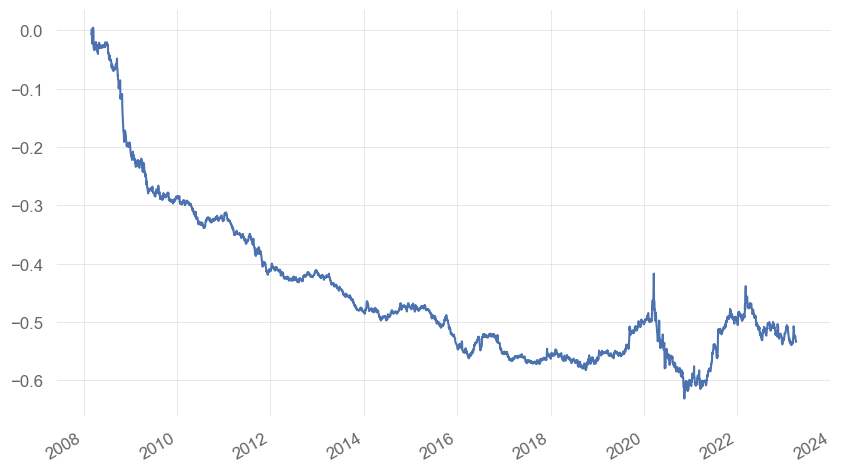

In [33]:
signal = results[P].ffill()
signal = signal[P].rolling(2).mean()
signal = signal[P].rolling(20).rank(axis=0,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal = signal[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<0.75] = None

signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).sum(1).replace({0:np.nan}).dropna()
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':PNL.mean()*1e4}).round(1)

<Axes: >

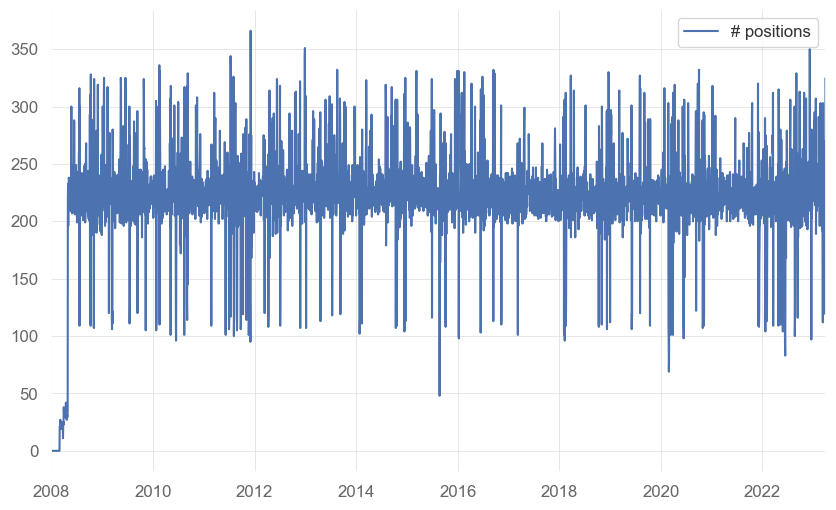

In [19]:
signal.count(1).plot(label ='# positions',legend=True)

<Axes: >

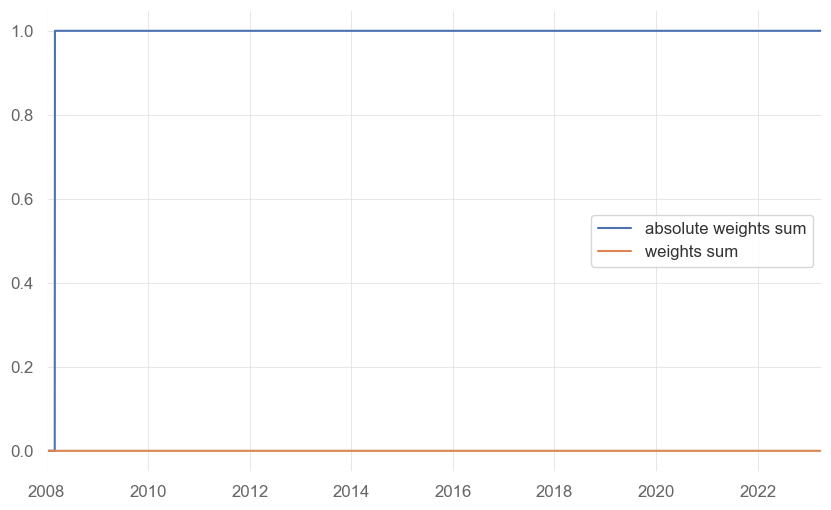

In [20]:
signal.abs().sum(1).plot(label = 'absolute weights sum',legend=True)
signal.sum(1).plot(label='weights sum',legend=True)